#### Authentication

create gee non profit project

In [33]:
import ee
ee.Authenticate()
ee.Initialize()

#4/1Ab_5qlnP5Q6eLQKUaOhmM-GKuDWSGDoOQxKuJcIpdt7YIoyh6zLow8qvREY


Successfully saved authorization token.


#### Read data

In [3]:
import ee
import numpy as np
import pandas as pd

from datetime import datetime

In [2]:
ee.Initialize() #init instance

In [3]:
#define region of interest
roi = ee.Geometry.Polygon([[[-74.8333, 10.5000], #sw 10° 30′ N, 74° 50′ O → (-74.8333, 10.5000)
                            [-74.3333, 10.5000], #se 10° 30′ N, 74° 20′ O → (-74.3333, 10.5000)
                            [-74.3333, 11.2500], #ne 11° 15′ N, 74° 20′ O → (-74.3333, 11.2500)
                            [-74.3333, 11.2500]  #nw 11° 15′ N, 74° 50′ O → (-74.8333, 11.2500)
                            ]])

In [4]:
#sentinel 2
sentinel = (ee.ImageCollection('COPERNICUS/S2_SR') #deprecated
            .filterBounds(roi)
            .filterDate('2023-01-01', '2023-12-31')
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) #cloud %
            .select(['B2','B3','B4','B8']))  # b, g, r, nir


/usr/local/anaconda3/lib/python3.12/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


In [5]:
# Sentinel-2 Harmonized Surface Reflectance (Level-2A)
sentinel = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
            .filterBounds(roi)
            .filterDate('2023-01-01', '2023-12-31')
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 90))
            .select(['B2','B3','B4','B8'])  # b, g, r, nir
            )

In [6]:
sentinel.size().getInfo()

238

In [7]:
dates = sentinel.aggregate_array('system:time_start').getInfo()

[datetime.fromtimestamp(t/1000).strftime('%Y-%m-%d') for t in dates][:5]

['2023-01-01', '2023-01-01', '2023-01-03', '2023-01-03', '2023-01-06']

In [8]:
len(dates)

238

define params e.g. turbidity

$t=\frac{B4 (\text{NIR})-B3 (\text{red})}{B4+B3}$

In [26]:
def add_turbidity(image): #relation r/b or tsm
    turb = image.normalizedDifference(['B4','B3']).rename('turbidity')
    return image.addBands(turb)

get images

In [27]:
base = sentinel.median() # ee.Image
turbidity = base.normalizedDifference(['B4','B3']) # (B4−B3)/(B4+B3)
turbidity = turbidity.rename('turbidity') # ee.Image

composite = base.addBands(turbidity).unmask(0) # ee.Image with 5 bands

In [28]:
type(composite)

ee.image.Image

In [29]:
patch_size, scale = 128, 10

In [30]:
proj = composite.projection().atScale(scale) # ee.Projection con CRS
reproj = composite.reproject(proj) #forces reprojection to 10 meters

#### Use

get region

In [50]:
lon, lat = -74.6, 11.0

half_m = (patch_size//2) * scale
meters_per_deg = 111320
half_deg = half_m / meters_per_deg

In [51]:
region = ee.Geometry.Rectangle([
    lon - half_deg, lat - half_deg,
    lon + half_deg, lat + half_deg
])

In [52]:
patch_feature = reproj.sampleRectangle(region=region,
                                       defaultValue=0
                                       )

In [53]:
patch_dict = patch_feature.toDictionary()
patch_data = patch_dict.getInfo()

to np

In [54]:
patch_data.keys()

dict_keys(['B2', 'B3', 'B4', 'B8', 'turbidity'])

In [55]:
len(patch_data['B2'])

129

In [56]:
bands = patch_data.keys()

arrays = [np.array(patch_data[b]) for b in bands]
tensor = np.stack(arrays, axis=0) #stack on axis 0 -> (5, 128, 128)

In [57]:
tensor.shape

(5, 129, 129)

In [58]:
np.save('batch.npy', tensor)

In [59]:
file = np.load('batch.npy')

In [60]:
a = file[0,:,:]

In [61]:
from matplotlib import pyplot as plt
import os
plt.rcParams['figure.dpi'] = 360
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
plt.rcParams['text.usetex'] = True

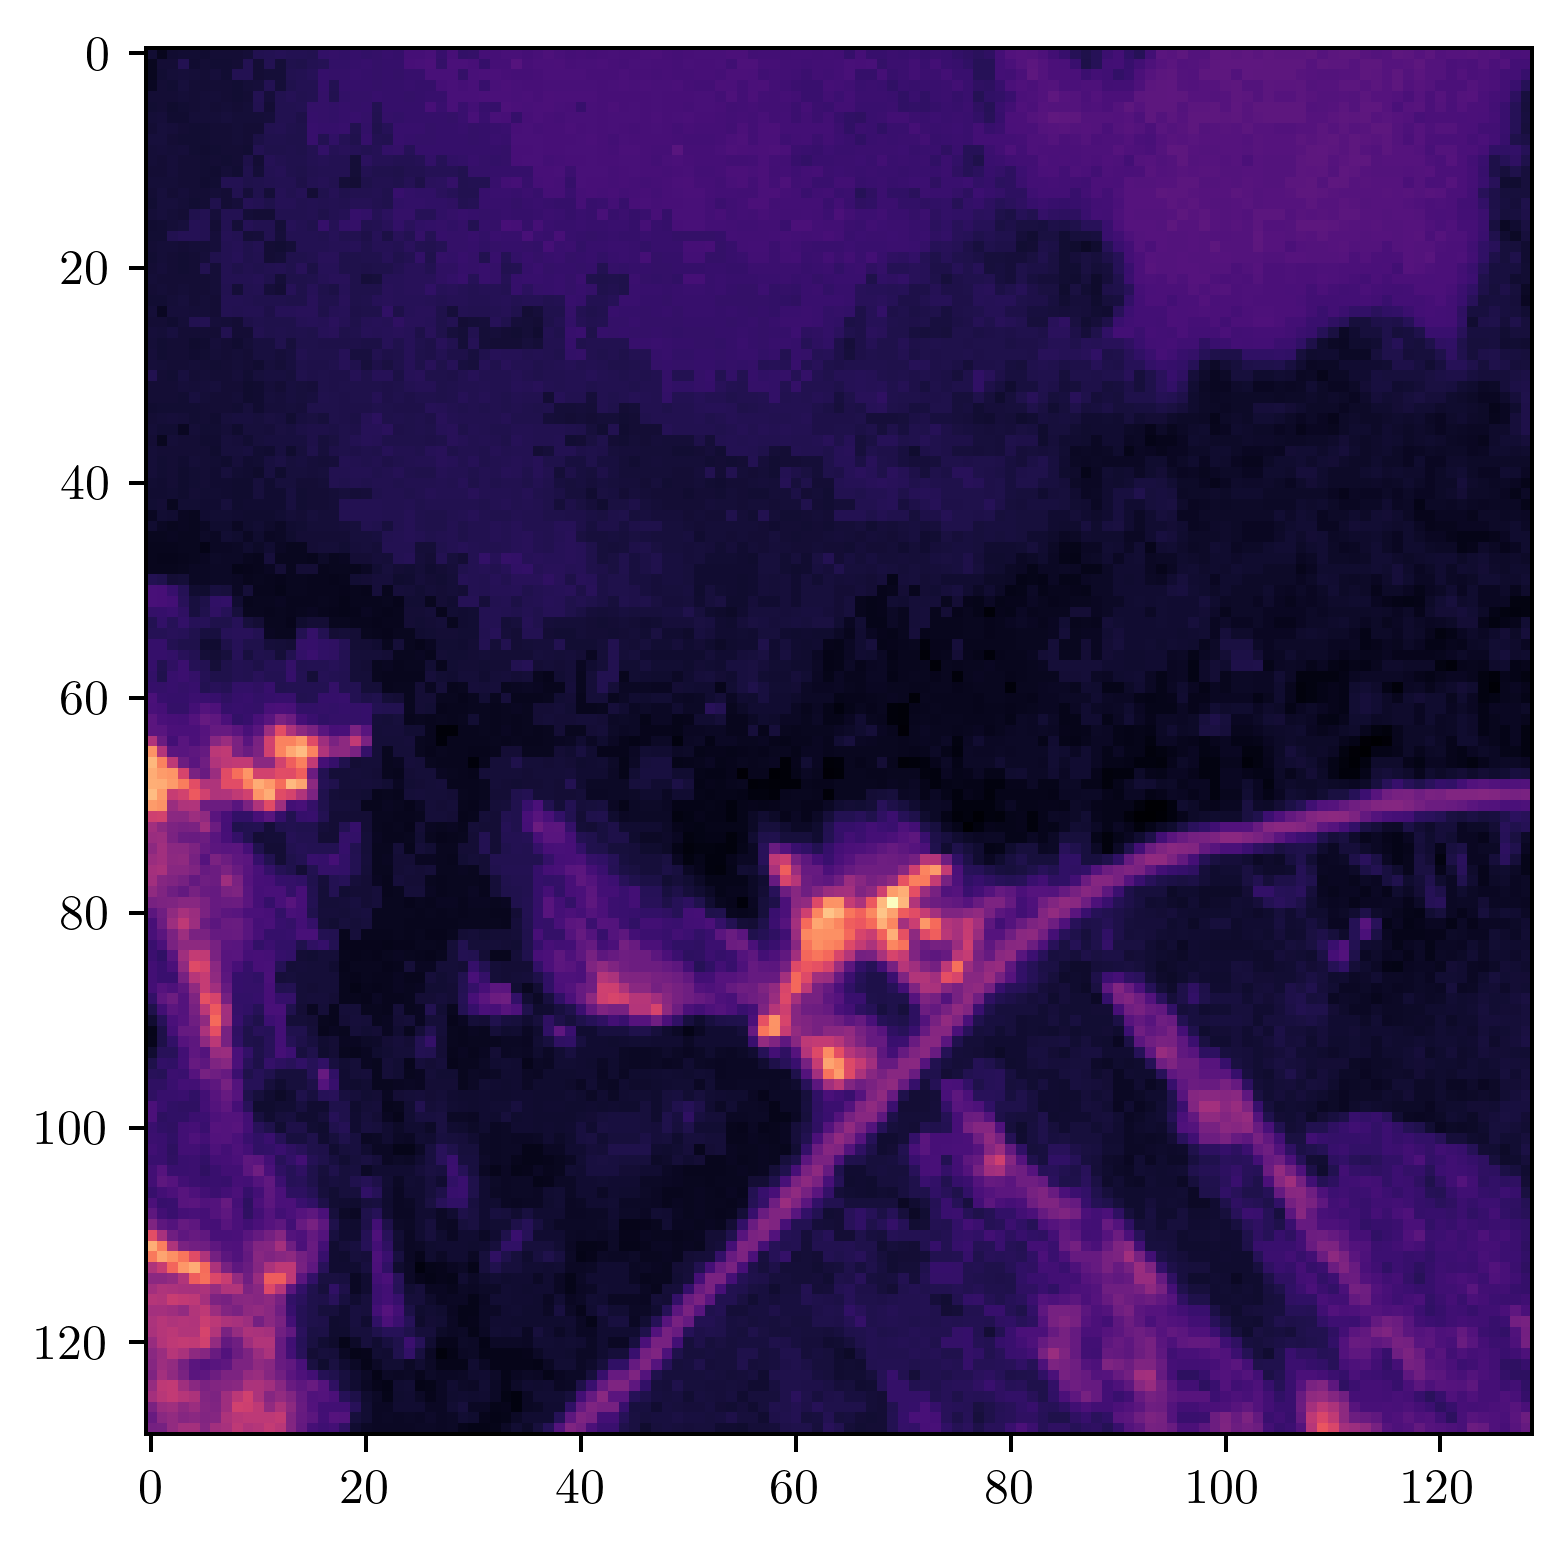

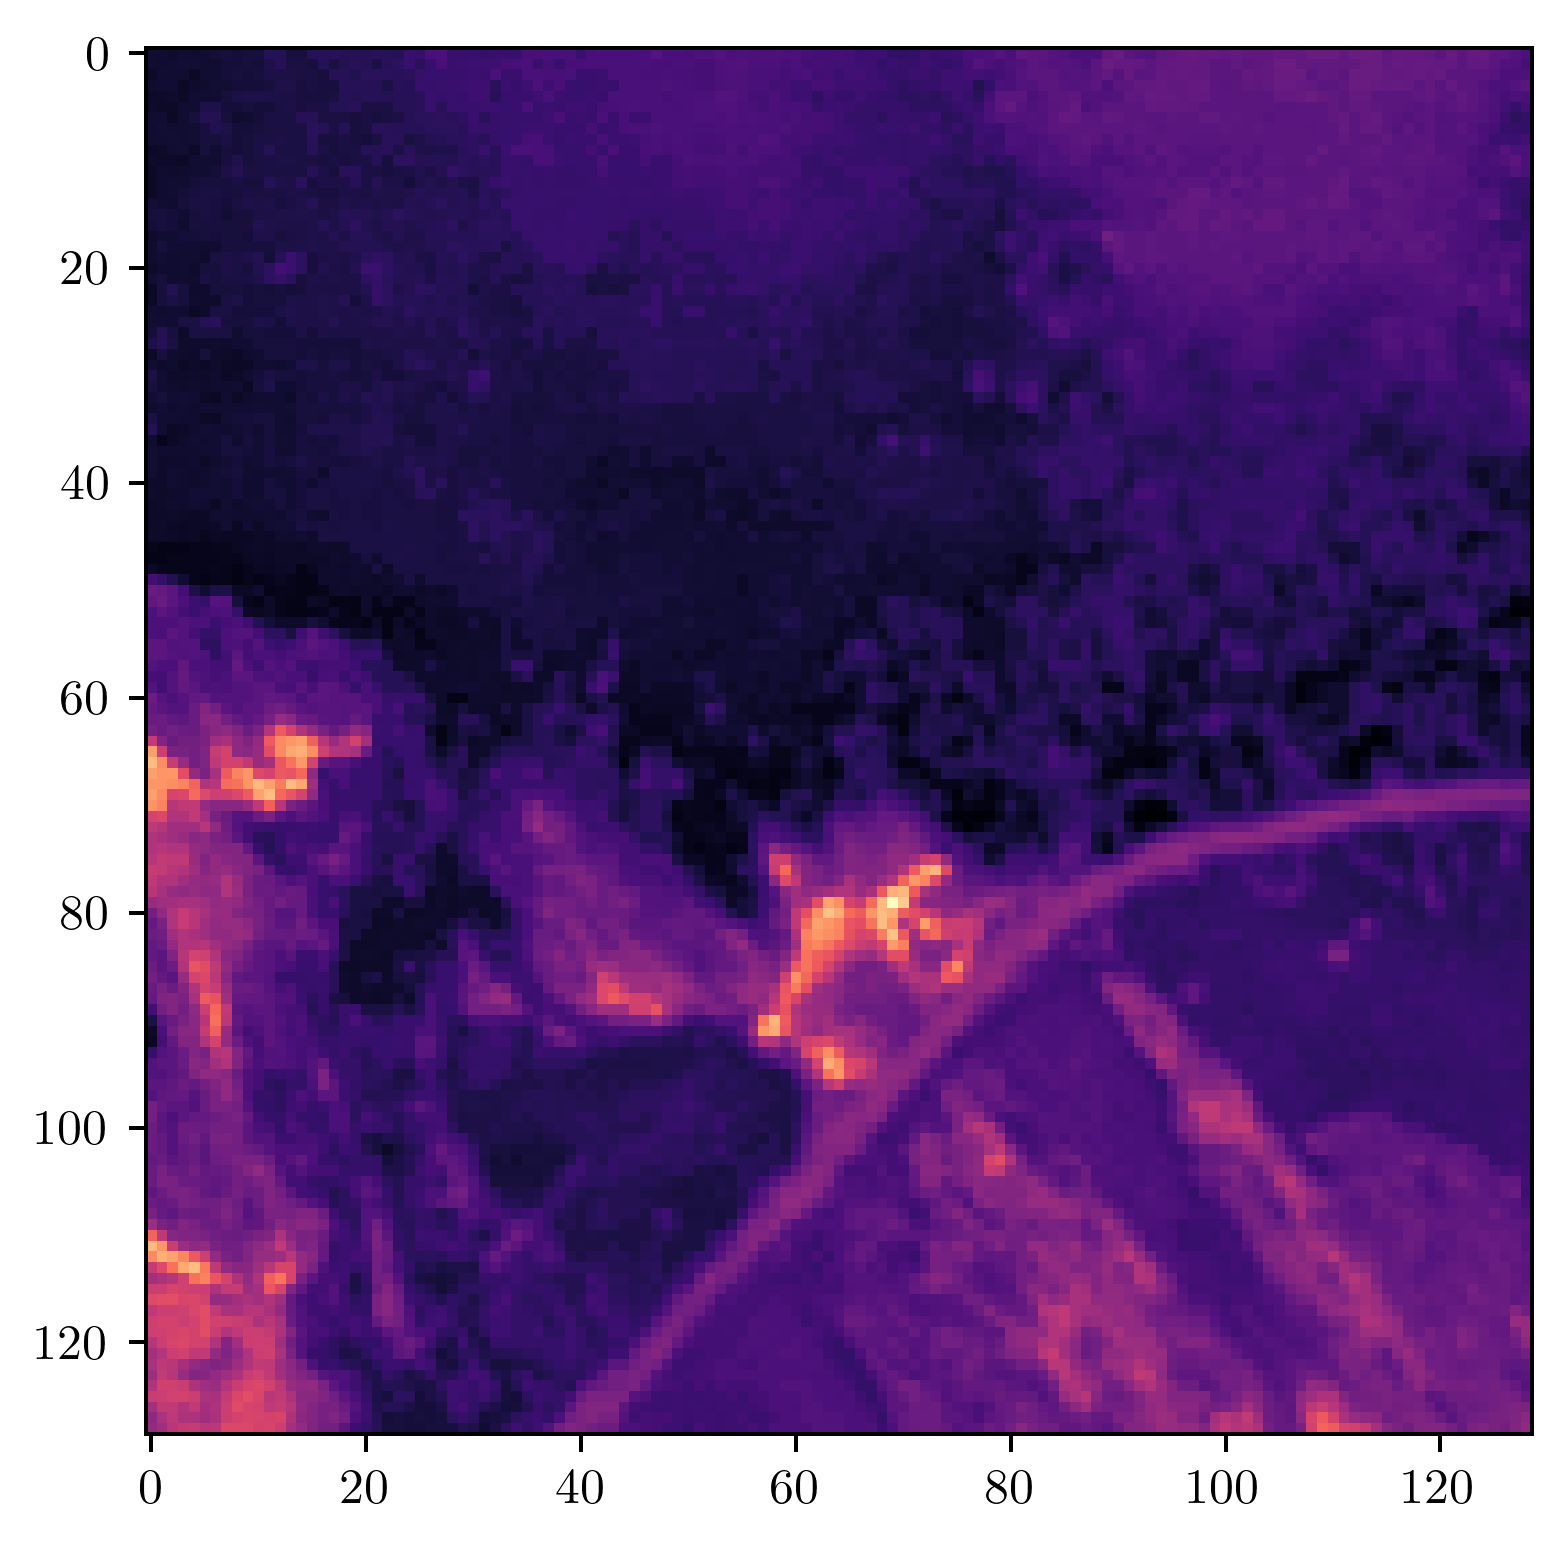

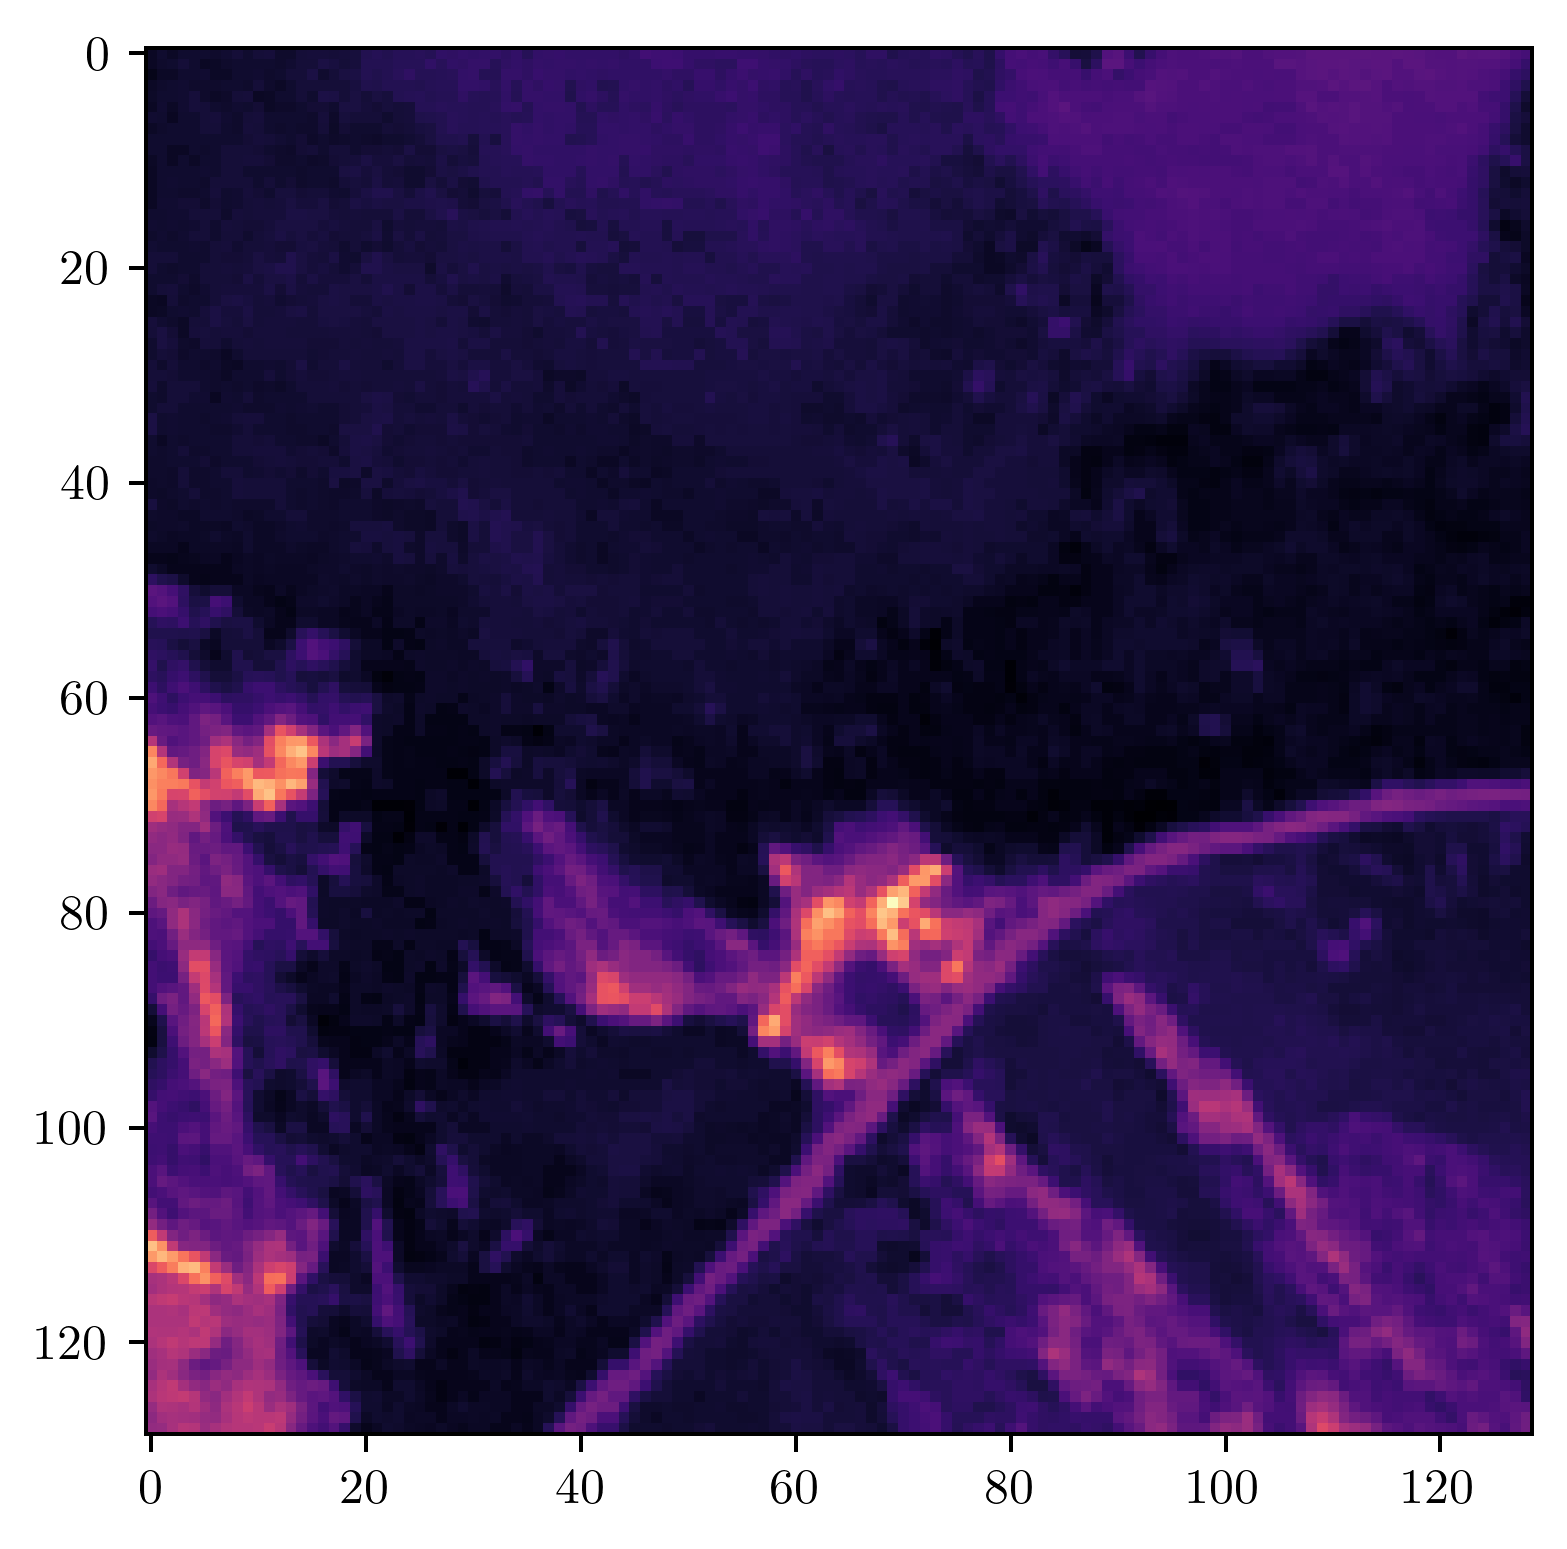

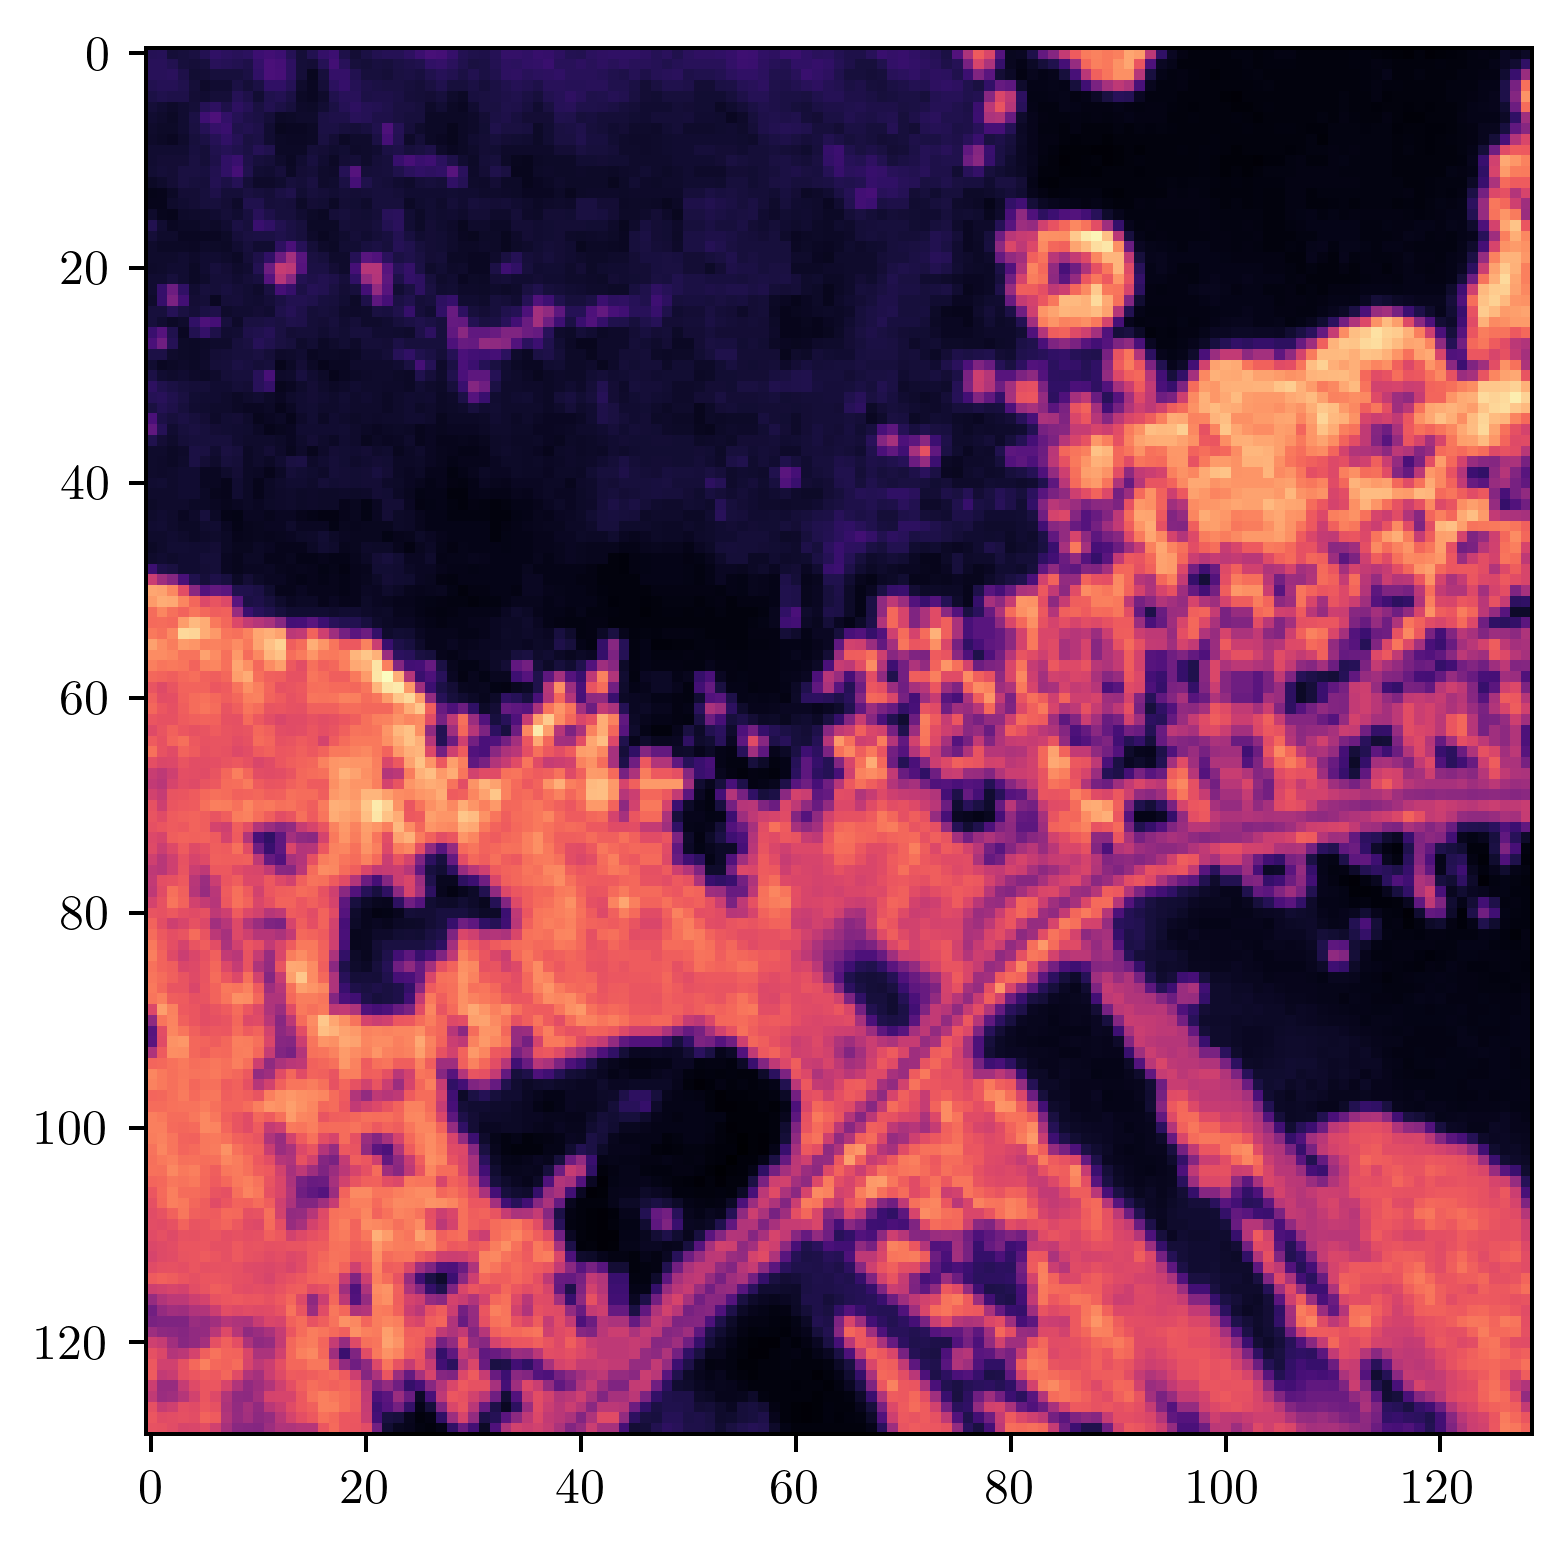

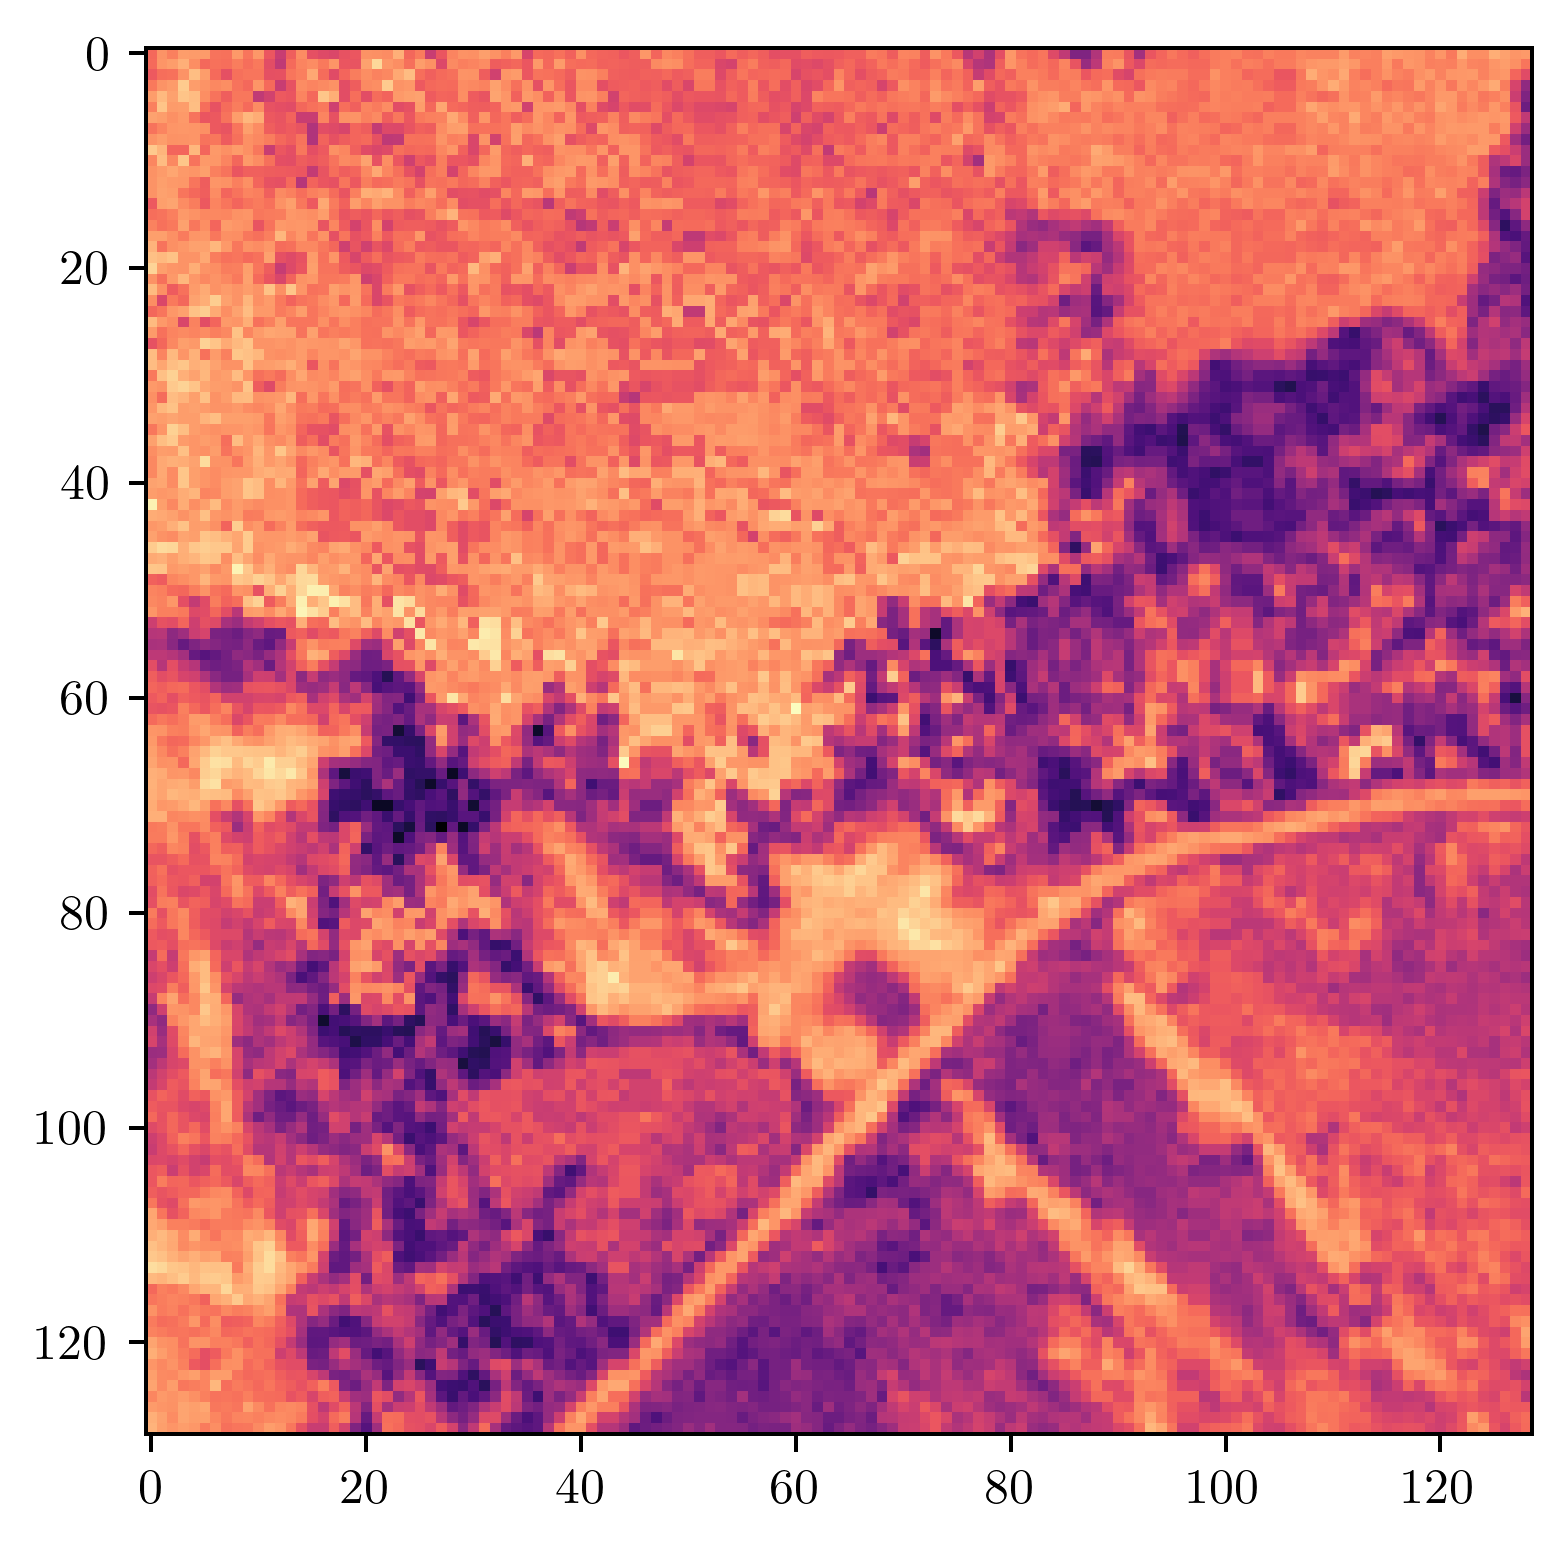

In [62]:
for img in file:
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(img, cmap='magma')

In [8]:
import pandas as pd
import numpy as np
import ee

# 0. Si no has autenticado aún, ejecuta:
# ee.Authenticate()

# 1. Inicializa Earth Engine
ee.Initialize()

# 2. Lee tu CSV con pandas (con columna 'id', 'latitud', 'longitud' y tus subíndices)
df_original = pd.read_csv('icam.csv')

# 3. Función para máscara de nubes en Sentinel-2
def maskClouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
         .And( qa.bitwiseAnd(cirrusBitMask).eq(0) )
    return image.updateMask(mask).divide(10000)

# 4. Convierte cada fila en ee.Feature, pasando NaN → None
def row_to_feature(row):
    geom = ee.Geometry.Point([row['longitud'], row['latitud']])
    props = {}
    for col, val in row.drop(['latitud','longitud']).items():
        # si es NaN, pásalo a None
        if pd.isna(val):
            props[col] = None
        else:
            # forzosamente Python built-ins JSON-serializable
            props[col] = val
    return ee.Feature(geom, props)

features = df_original.apply(row_to_feature, axis=1).tolist()
fc = ee.FeatureCollection(features)

# 5. Función que añade índices y bandas de interés
def addIndices(img):
    turb  = img.normalizedDifference(['B3','B11']).rename('ND_turbidez')
    mndwi = img.normalizedDifference(['B3','B11']).rename('MNDWI')
    b3    = img.select('B3').rename('B3')
    b8    = img.select('B8').rename('B8')
    b11   = img.select('B11').rename('B11')
    return img.addBands([turb, mndwi, b3, b8, b11])

# 6. Construye la colección de Sentinel-2 y añade índices
sentinel = (
    ee.ImageCollection('COPERNICUS/S2')
      .filterDate('2024-01-01', '2024-05-01')
      .filterBounds(fc)
      .map(maskClouds)
      .map(addIndices)
)

# 7. Mediana de todas las bandas e índices
idx_img = sentinel.median()

# 8. Muestrea en tus puntos
sampled = idx_img.sampleRegions(
    collection=fc,
    scale=10,
    geometries=False
)

# 9. Descarga los resultados (si son pocos puntos)
info = sampled.getInfo()['features']
rows = [f['properties'] for f in info]
df_gee = pd.DataFrame(rows)

# 10. Merge con tu DataFrame original usando 'id'
df_final = df_original.merge(df_gee, on='id')

# 11. Guarda la matriz final
df_final.to_csv('matriz_entrenamiento.csv', index=False)
print("Listo: 'matriz_entrenamiento.csv' generada.")


EEException: reduce.median: Error in map(ID=20240206T155521_20240206T155519_T17PMP):
Image.select: Band pattern 'QA60' did not match any bands. Available bands: [B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B10, B11, B12, MSK_CLASSI_OPAQUE, MSK_CLASSI_CIRRUS, MSK_CLASSI_SNOW_ICE]